In [102]:
# Import the necessary packages
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
import random
import os
import cv2
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [103]:
# Set a consistent random seed for reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [104]:
# Load the pre-trained CNN model
model_path = '/content/drive/MyDrive/Colab Notebooks/RL-AutoNav/cnn_model.h5'
model = load_model(model_path)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [105]:
# Load video file
video_file = '/content/drive/MyDrive/Colab Notebooks/RL-AutoNav/Video_testing.mp4'
cap = cv2.VideoCapture(video_file)

In [106]:
# Get FPS and total frames
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration = total_frames / fps if fps > 0 else 0
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

In [107]:
# Skip empty videos
if total_frames == 0 or fps == 0:
    print(f"Skipping {video_file}: No frames available.")
    cap.release()
    exit()

print(f"FPS: {fps}, Total Frames: {total_frames}, Duration: {duration:.2f} seconds")

FPS: 25.0, Total Frames: 500, Duration: 20.00 seconds


In [108]:
frames, frame_indices, original_frames = [], [], []
frame_count = 0

# Extract frames at intervals (e.g., every second)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    if frame_count % int(fps) == 0:
        resized_frame = cv2.resize(frame, (128, 128)) / 255.0  # Normalize for model input
        frames.append(resized_frame)
        frame_indices.append(frame_count)
        original_frames.append(frame)  # Keep original resolution frames
    frame_count += 1

cap.release()
frames = np.array(frames)
print(f"Extracted {len(frames)} frames.")

Extracted 20 frames.


In [109]:
# Class labels
class_labels = ['stop', 'left', 'right', 'forward']
label_to_index = {label: idx for idx, label in enumerate(class_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

In [110]:
# Model predictions
video_predictions = model.predict(frames)
predicted_classes = np.argmax(video_predictions, axis=1)
decoded_predictions = [index_to_label[pred] for pred in predicted_classes]

# Print predictions
print("Predictions:")
true_labels = []
for i, label in zip(frame_indices, decoded_predictions):
    true_labels.append(label)
    print(f"Frame {i}: {label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
Predictions:
Frame 0: stop
Frame 25: stop
Frame 50: stop
Frame 75: forward
Frame 100: right
Frame 125: stop
Frame 150: stop
Frame 175: stop
Frame 200: stop
Frame 225: stop
Frame 250: stop
Frame 275: stop
Frame 300: stop
Frame 325: stop
Frame 350: forward
Frame 375: forward
Frame 400: forward
Frame 425: forward
Frame 450: forward
Frame 475: forward


In [111]:
# Annotate and save video
output_path = '/content/drive/MyDrive/Colab Notebooks/RL-AutoNav/annotated_video.mp4'
out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), 1, (frame_width, frame_height))

for i, frame in enumerate(original_frames):
    text_position = (10, frame_height - 50)  # Move text downward
    annotated_frame = cv2.putText(frame, decoded_predictions[i], text_position,
                                  cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3, cv2.LINE_AA)  # Increase font size
    out.write(annotated_frame)

out.release()
print(f"Annotated video saved at: {output_path}")

Annotated video saved at: /content/drive/MyDrive/Colab Notebooks/RL-AutoNav/annotated_video.mp4


In [112]:
# Compute test accuracy
true_encoded = np.array([label_to_index[label] for label in true_labels])
test_accuracy = np.mean(predicted_classes == true_encoded)
print(f"Test Accuracy: {test_accuracy:.2f}")

Test Accuracy: 1.00


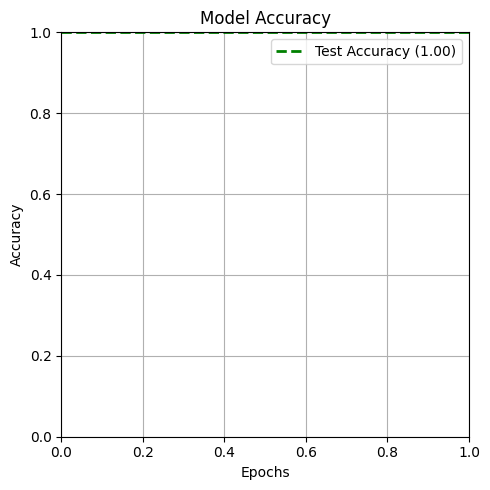

In [113]:
# Plot test accuracy
plt.figure(figsize=(5, 5))
plt.axhline(y=test_accuracy, color='green', linestyle='--', label=f'Test Accuracy ({test_accuracy:.2f})', linewidth=2)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()